In [44]:
# install dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


In [47]:
# Data Loading and Initial Overview
file_path = r"click_through_analysis/data/ad_10000records.csv"
df = pd.read_csv(file_path)

df.info()

FileNotFoundError: [Errno 2] No such file or directory: 'click_through_analysis/data/ad_10000records.csv'

There seem to be no missing values in the dataset and the data types for each columns appear good

In [12]:
df.head()

NameError: name 'df' is not defined

In [13]:
# Checking for Missing Values
df.isnull().sum()

NameError: name 'df' is not defined

In [14]:
# Checking for duplicates
print(f'There are {df.duplicated().sum()} missing values in the dataset')

NameError: name 'df' is not defined

In [15]:
# Descriptive Statistics
df.describe().T

NameError: name 'df' is not defined

The Standard Deviation for 'Area Income' too high, there could be issue with the data in the column

## Exploratory Data Ananlysis

In [16]:
# Convert 'Timestamp' to datetime objects
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract date and time components
df['Hour'] = df['Timestamp'].dt.hour
df['DayofWeek'] = df['Timestamp'].dt.dayofweek  # 0: Monday, 6: Sunday
df['Month'] = df['Timestamp'].dt.month

NameError: name 'df' is not defined

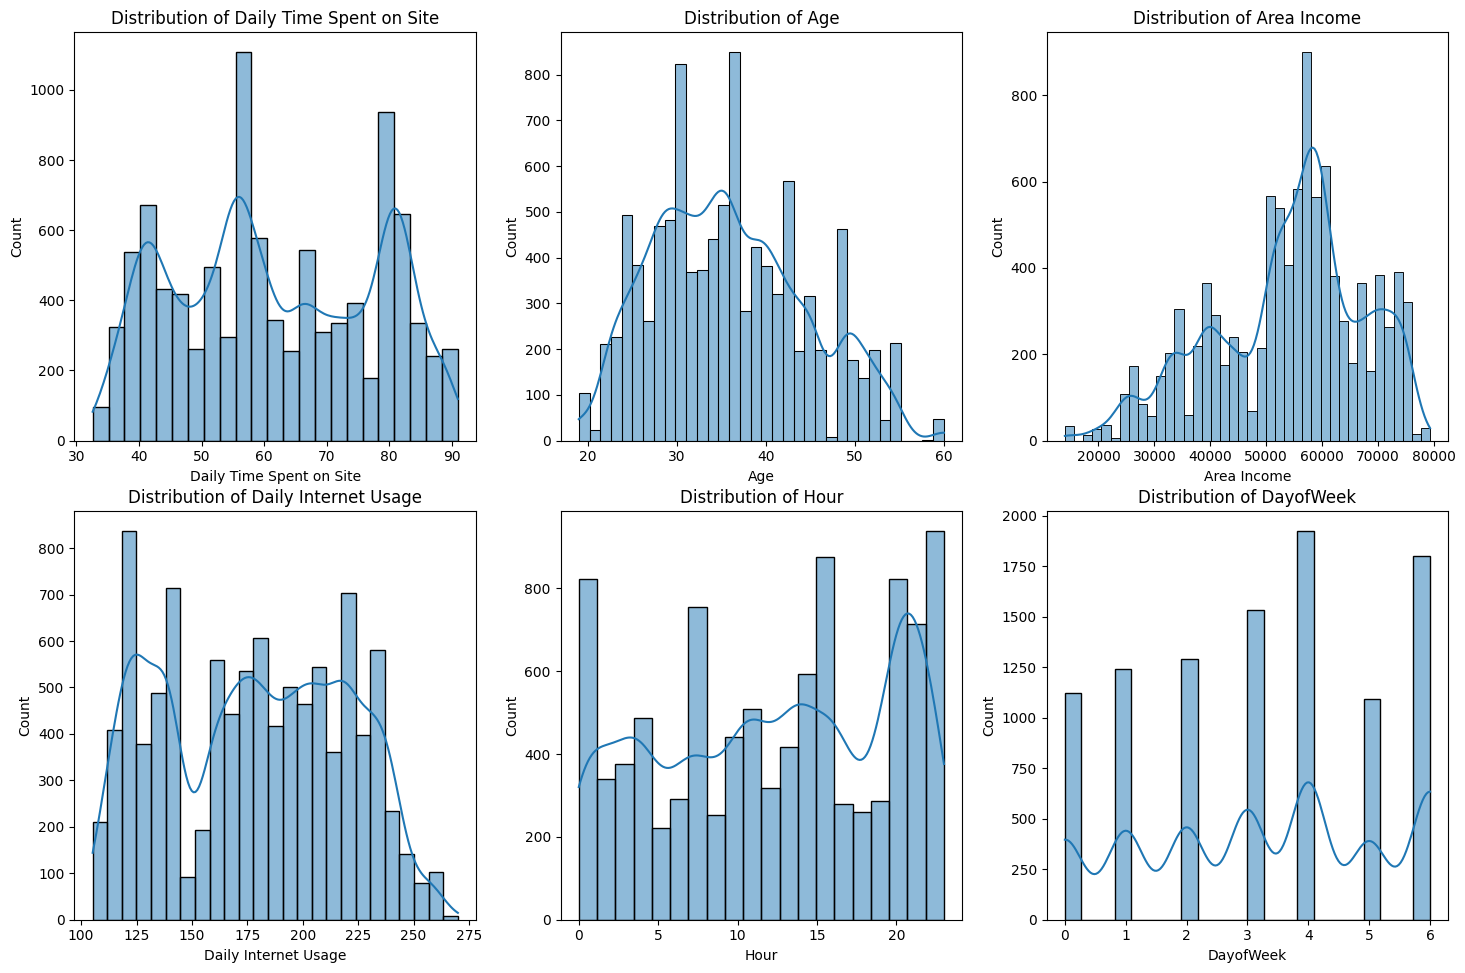

In [ ]:
# Calculate the number of numerical columns
num_cols = len(df.select_dtypes(include='number').columns)

# Calculate the number of rows and columns for the subplot grid
num_rows = 2
num_cols_grid = 3

# Create a figure and axes with enough subplots
fig, axes = plt.subplots(num_rows, num_cols_grid, figsize=(15, 10))
fig.tight_layout(pad=3.0)



axes = axes.flatten()

# Enumerate through numerical columns and use the index for subplot placement
for i, column in enumerate(df.select_dtypes(include='number').columns.drop(['Clicked on Ad', 'Month'])):
    sns.histplot(df[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)


plt.show()

The numerical columns will be tranform to reduce skewness and to achieve a relatively normal distribution

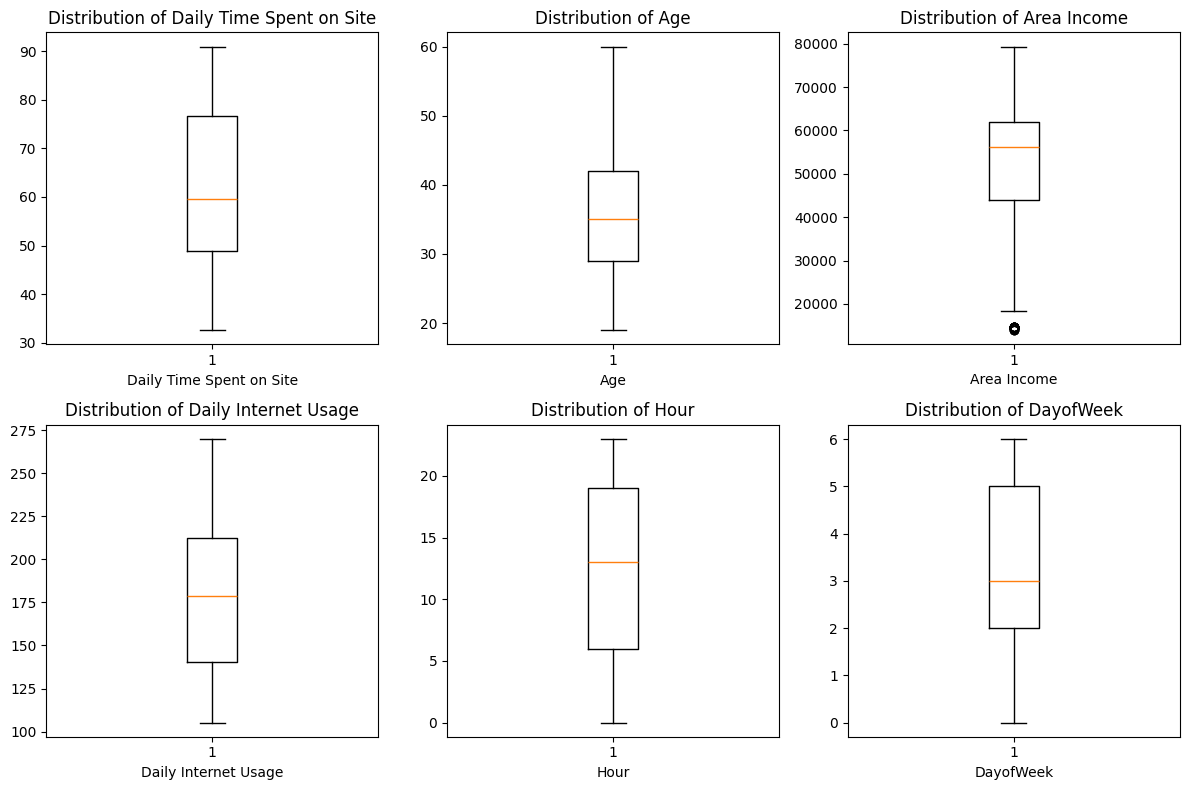

In [ ]:
plt.figure(figsize=(12, 8))

# Enumerate through numerical columns and use the index for subplot placement
for i, column in enumerate(df.select_dtypes(include='number').columns.drop(['Clicked on Ad', 'Month'])):
    plt.subplot(2, 3, i + 1)  # Use i + 1 to get subplot index starting from 1
    plt.boxplot(df[column])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()


In [17]:
for x, y in enumerate(df.columns):
    print(f"Column '{y}' has {df[y].nunique()} unique values")

NameError: name 'df' is not defined

In [18]:
plt.figure(figsize=(12, 6))

# Enumerate through numerical columns and use the index for subplot placement
sns.heatmap(df[df.select_dtypes(include='number').columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Matrix')


NameError: name 'df' is not defined

<Figure size 1200x600 with 0 Axes>

The coulmns are not highly correlated

## Analysis of Target Variable (Clicked on Ad)

In [19]:
for i, column in enumerate(df.select_dtypes(include='number').columns.drop('Clicked on Ad')):
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=df, x=column, hue='Clicked on Ad', kde=True)
    plt.title(f'Distribution of {column} by Clicked on Ad')
    plt.xlabel(column)
    plt.tight_layout()
    plt.show()

NameError: name 'df' is not defined

In [20]:
# Select relevant numerical columns for analysis, excluding 'Clicked on Ad'
columns_to_analyze = df.select_dtypes(include=['number']).columns. \
drop(['Clicked on Ad','DayofWeek', 'Month'], errors='ignore')

# Function to format and create bins for 'Area Income' and 'Daily Internet Usage'
def create_bins(df, column, num_bins, min_value=None, max_value=None):
    # Ensure the column data is numeric
    df[column] = pd.to_numeric(df[column], errors='coerce')


    if min_value and max_value:
        # Use custom min and max for 'Area Income'
        bin_edges = np.linspace(min_value, max_value, num_bins + 1)
    else:
        # For other columns, calculate min and max from data
        min_value = np.floor(df[column].min() / 10) * 10
        max_value = np.ceil(df[column].max() / 10) * 10
        bin_edges = np.linspace(min_value, max_value, num_bins + 1)

    # Sort the bin edges in increasing order
    bin_edges = np.sort(bin_edges)

    bin_edges = np.round(bin_edges, -1)

    # Bin the data and drop duplicate edges
    df['binned'] = pd.cut(df[column], bins=bin_edges, duplicates='drop',
                          include_lowest=True)

    # Get unique bins and create labels
    unique_bins = df['binned'].cat.categories
    bin_labels = [f'{int(b.left)}-{int(b.right)}' for b in unique_bins]

    # Re-apply labels to the binned column
    df['binned'] = pd.cut(df[column], bins=bin_edges, labels=bin_labels,
                          include_lowest=True, duplicates='drop')

    return df, bin_edges

# Group by each column (binned) and calculate total clicks, then plot
for column in columns_to_analyze:
    # Apply custom binning logic for 'Area Income' and 'Daily Internet Usage'
    if column == 'Area Income':
        # Custom min and max for 'Area Income' (13,000 to 80,000)
        df, bin_edges = create_bins(df, column, 10, min_value=13000, max_value=80001)
    elif column == 'Daily Internet Usage':
        # Use default binning for 'Daily Internet Usage' with 8 bins
        df, bin_edges = create_bins(df, column, 8)
    else:
        # For other columns, use standard binning with 10 bins
        df, bin_edges = create_bins(df, column, 10)

    # Group by bins and calculate total clicks
    click_counts = df.groupby('binned')['Clicked on Ad'].sum().reset_index()

    # Create bar plot
    plt.figure(figsize=(12, 6))  # Adjust figure size to accommodate labels
    sns.barplot(x='binned', y='Clicked on Ad', data=click_counts)

    # Annotate each bar
    for index, row in click_counts.iterrows():
        plt.text(
            index,  # x-coordinate (position of the bar)
            row['Clicked on Ad'] + row['Clicked on Ad'] * 0.008,
            str(row['Clicked on Ad']),  # Value to display
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

    # Title and labels
    plt.title(f'Total Clicks by {column}')
    plt.xlabel(f'{column} Bins (in Multiples of 10)')
    plt.ylabel('Total Clicks')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Drop 'DayofWeek', 'Hour', and 'Month' columns after all necessary processing
df.drop(columns=['DayofWeek', 'Hour', 'Month'], errors='ignore', inplace=True)


NameError: name 'df' is not defined

In [21]:
# Function to format days of the week
def format_day(day_number):
    days = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
    return days[day_number]

# Function to format months
def format_month(month_number):
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep",
              "Oct", "Nov", "Dec"]
    return months[month_number - 1]

# Extract features from the Timestamp column
df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
df['Day of Week'] = pd.to_datetime(df['Timestamp']).dt.dayofweek.apply(format_day)
df['Month'] = pd.to_datetime(df['Timestamp']).dt.month.apply(format_month)

# Bin the 'Hour' column into 6 bins
df['Hour Bin'] = pd.cut(df['Hour'], bins=6, labels=['0-3', '4-7', '8-11',
                          '12-15', '16-19', '20-23'], include_lowest=True)

# Define custom order for days of the week and months
day_order = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep",
               "Oct", "Nov", "Dec"]

NameError: name 'df' is not defined

In [22]:
# Create the plot
plt.figure(figsize=(5, 3))
ax = sns.countplot(x='Gender', hue='Clicked on Ad', data=df)
plt.title('Clicked on Ad by Gender')

# Annotate the bars with their counts
for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2  # Center the annotation
    y = height + 0.02 * max(df['Clicked on Ad'].value_counts())

    ax.annotate(
        f'{int(height)}',
        (x, y),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Ensure that the legend appears and is positioned correctly
plt.legend(title='Clicked on Ad', loc='lower right', bbox_to_anchor=(1, 0))
# Display the plot
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

<Figure size 500x300 with 0 Axes>

In [23]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Day of Week', hue='Clicked on Ad', data=df)
plt.title('Clicked on Ad by Day of the Week')

# Annotate the bars with their counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# 'DayofWeek' is numeric (0-6), set the labels to days of the week
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

<Figure size 800x400 with 0 Axes>

In [24]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Month', hue='Clicked on Ad', data=df)
plt.title('Clicked on Ad by Month')

# Annotate the bars with their counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# 'Month is numeric (1-7), set the labels to days of the week
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

<Figure size 800x400 with 0 Axes>

## Model Building Before Preprocessing and Feature Engineering

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder



In [26]:
df=df.drop('Timestamp', axis = 1).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
df = dv.fit_transform(df)
df = pd.DataFrame(df, columns=dv.get_feature_names_out())
y = df['Clicked on Ad']
X = df.drop('Clicked on Ad', axis=1)
y = LabelEncoder().fit_transform(y)
x_full_train, x_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_full_train, y_full_train, test_size=0.25, random_state=42)

NameError: name 'df' is not defined

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix

lr_model = LogisticRegression(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)



In [ ]:
# Calculate evaluation metrics
models = {'Logistic Regression': lr_model, 'Random Forest': rf_model,
          'XGBoost': xgb_model, 'Gradient Boosting': gb_model,
          'Decision Tree': dt_model}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, model.predict_proba(x_val)[:, 1])
    cm = confusion_matrix(y_val, y_pred)

    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, \
    Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {roc_auc:.2f}")
    print(f"Confusion Matrix:\n{cm}\n")




Logistic Regression - Accuracy: 0.69, Precision: 0.70,     Recall: 0.65, F1: 0.67, AUC: 0.75
Confusion Matrix:
[[758 272]
 [340 630]]

Random Forest - Accuracy: 0.87, Precision: 0.87,     Recall: 0.86, F1: 0.86, AUC: 0.94
Confusion Matrix:
[[906 124]
 [140 830]]

XGBoost - Accuracy: 0.86, Precision: 0.86,     Recall: 0.85, F1: 0.86, AUC: 0.94
Confusion Matrix:
[[898 132]
 [146 824]]

Gradient Boosting - Accuracy: 0.81, Precision: 0.83,     Recall: 0.78, F1: 0.80, AUC: 0.90
Confusion Matrix:
[[873 157]
 [215 755]]

Decision Tree - Accuracy: 0.82, Precision: 0.82,     Recall: 0.82, F1: 0.82, AUC: 0.82
Confusion Matrix:
[[850 180]
 [172 798]]



In [ ]:
# Calculate evaluation metrics with full_train and y_test set
models = {'Logistic Regression': lr_model, 'Random Forest': rf_model,
          'XGBoost': xgb_model, 'Gradient Boosting': gb_model,
          'Decision Tree': dt_model}

for name, model in models.items():
    model.fit(x_full_train, y_full_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(x_val)[:, 1])
    cm = confusion_matrix(y_test, y_pred)

    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, \
    Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {roc_auc:.2f}")
    print(f"Confusion Matrix:\n{cm}\n")


Logistic Regression - Accuracy: 0.70, Precision: 0.71,     Recall: 0.66, F1: 0.68, AUC: 0.50
Confusion Matrix:
[[745 269]
 [333 653]]

Random Forest - Accuracy: 0.89, Precision: 0.89,     Recall: 0.88, F1: 0.89, AUC: 0.49
Confusion Matrix:
[[911 103]
 [117 869]]

XGBoost - Accuracy: 0.89, Precision: 0.90,     Recall: 0.89, F1: 0.89, AUC: 0.49
Confusion Matrix:
[[914 100]
 [112 874]]

Gradient Boosting - Accuracy: 0.83, Precision: 0.85,     Recall: 0.79, F1: 0.82, AUC: 0.50
Confusion Matrix:
[[882 132]
 [208 778]]

Decision Tree - Accuracy: 0.83, Precision: 0.82,     Recall: 0.84, F1: 0.83, AUC: 0.49
Confusion Matrix:
[[832 182]
 [162 824]]



## Data Preprocessing and Feature Engineering

In [ ]:
df = df.drop_duplicates()

print(f'Number of duplicates {df.duplicated().sum()}')

Number of duplicates 0


In [ ]:
df['Is_Weekend'] = df['Day of Week'].apply(lambda x: 1 if x in [5, 6] else 0)
df['Time_Spent_Ratio'] = df['Daily Time Spent on Site'] / df['Daily Internet Usage']
df['Income_Per_Age'] = df['Area Income'] / df['Age']
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 19, 29, 49, 100],
                         labels=['Teen', 'Young Adult', 'Adult', 'Senior'])
df['Income_Bracket'] = pd.qcut(df['Area Income'], q=3, labels=['Low', 'Middle', 'High'])


In [37]:
df.info()

NameError: name 'df' is not defined

In [28]:
from scipy.stats import boxcox

# Numeric columns to transform
numeric_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']

# Apply Box-Cox transformation
for col in numeric_cols:
    # Check if the column has any non-positive values
    if (df[col] <= 0).any():
        print(f"Column '{col}' contains non-positive values, cannot apply Box-Cox transformation.")
    else:
        # Apply Box-Cox transformation
        transformed_data, lambda_value = boxcox(df[col])
        df[col] = transformed_data
        print(f"Applied Box-Cox transformation to '{col}', lambda: {lambda_value}")


NameError: name 'df' is not defined

In [29]:
num_cols = len(df.select_dtypes(include='number').columns)

num_rows = 4
num_cols_grid = 2

fig, axes = plt.subplots(num_rows, num_cols_grid, figsize=(15, 15))
fig.tight_layout(pad=3.0)



axes = axes.flatten()

# Enumerate through numerical columns and use the index for subplot placement
for i, column in enumerate(df.select_dtypes(include='number').columns.drop(['Clicked on Ad', 'Is_Weekend'])):
    sns.histplot(df[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)


plt.show()

NameError: name 'df' is not defined

In [30]:
plt.figure(figsize=(12, 8))

# Enumerate through numerical columns and use the index for subplot placement
for i, column in enumerate(df.select_dtypes(include='number').columns.drop(['Clicked on Ad', 'Is_Weekend'])):
    plt.subplot(2, 4, i + 1)  # Use i + 1 to get subplot index starting from 1
    plt.boxplot(df[column])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

<Figure size 1200x800 with 0 Axes>

In [31]:
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder

df=df.drop('Timestamp', axis = 1).to_dict(orient='records')

NameError: name 'df' is not defined

In [32]:
dv = DictVectorizer(sparse=False)
df = dv.fit_transform(df)
scaler = RobustScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=dv.get_feature_names_out())
y = df['Clicked on Ad']
X = df.drop('Clicked on Ad', axis=1)
y = LabelEncoder().fit_transform(y)
x_full_train, x_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_full_train, y_full_train, test_size=0.25, random_state=42)

NameError: name 'df' is not defined

## Building a baseline model

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier


In [34]:
# Calculate evaluation metrics
models = {'Logistic Regression': lr_model, 'Random Forest': rf_model,
          'XGBoost': xgb_model, 'Gradient Boosting': gb_model,
          'Decision Tree': dt_model}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, model.predict_proba(x_val)[:, 1])
    cm = confusion_matrix(y_val, y_pred)

    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, \
    Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {roc_auc:.2f}")
    print(f"Confusion Matrix:\n{cm}\n")

NameError: name 'lr_model' is not defined

## Model with Hyperparameter Tuning

In [35]:
lr_model = LogisticRegression(random_state=42)


param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization type
    'solver': ['lbfgs', 'liblinear', 'saga']  # Solver algorithm for optimization
}


grid_search = GridSearchCV(estimator=lr_model,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy',
                           n_jobs=-1,  # Use all processors
                           verbose=2)


grid_search.fit(x_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print(f"Best Cross-Validation Accuracy: {best_score: .2f}")



NameError: name 'x_train' is not defined

In [36]:
# Train the best model with full training data
best_model = grid_search.best_estimator_
best_model.fit(x_full_train, y_full_train)

# Evaluate the model on the test set
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, \
Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {roc_auc:.2f}")
print(f"Confusion Matrix:\n{cm}\n")


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'